# Example usage of ABCI-Categorical-GP

This notebook illustrates the example usage of ABCI with a categorical
distribution over graphs and a GP mechanism model. This setup scales up to systems with
four variables.

In [4]:
# imports
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch.distributions as dist
from matplotlib.ticker import MaxNLocator

from src.abci_categorical_gp import ABCICategoricalGP as ABCI
from src.environments.generic_environments import *
from src.models.gp_model import get_graph_key, gather_data


First, we generate a ground truth environment/SCM.

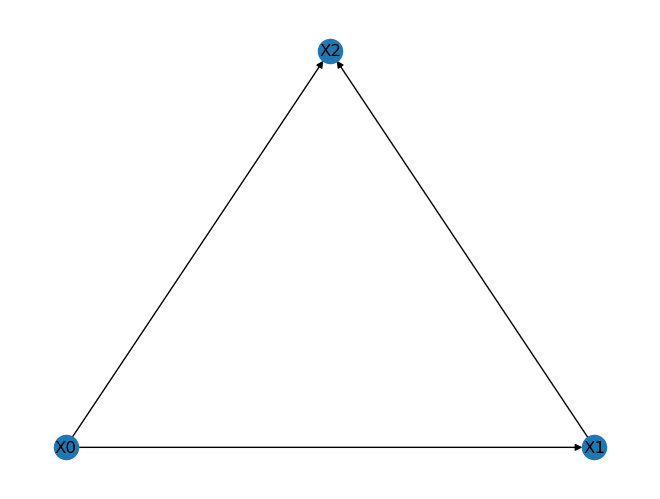

In [2]:
# specify the number of nodes and (optionally) a query of interventional variables
num_nodes = 3
# interventional_queries = None
interventional_queries = [InterventionalDistributionsQuery(['X2'], {'X1': dist.Uniform(3, 4.)})]

# generate the ground truth environment
env = BiDiag(num_nodes,
             num_test_queries=10,
             interventional_queries=interventional_queries)

# plot true graph
nx.draw(env.graph, nx.planar_layout(env.graph), labels=dict(zip(env.graph.nodes, env.graph.nodes)))


Next, we can examine the ground truth mechanisms.

torch.Size([100, 1])
output shape is currently f_dist.mean torch.Size([100])


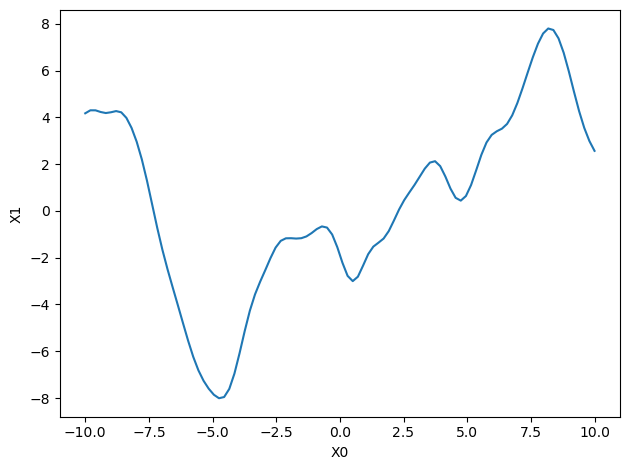

In [6]:
# plotting a univariate mechanism
node = 'X1'  # target node
num_points = 100
xrange = torch.linspace(-10., 10., num_points).unsqueeze(1)
print(xrange.shape)
ytrue = env.mechanisms[node](xrange, prior_mode=False).detach()

plt.figure()
plt.plot(xrange, ytrue)
plt.xlabel('X0')
plt.ylabel(node)
plt.tight_layout()

In [ ]:
# plotting a bivariate mechanism
node = 'X2'  # target node
num_points = 100
xrange = torch.linspace(-7., 7., num_points)
yrange = torch.linspace(-7., 7., num_points)
xgrid, ygrid = torch.meshgrid(xrange, yrange)
ztrue = env.mechanisms[node](torch.stack((xgrid, ygrid), dim=2).view(-1, 2))
zmin = ztrue.min().item()
zmax = ztrue.max().item()
print(f'Function values for {node} in range [{zmin, zmax}].')
ztrue = ztrue.detach().view(num_points, num_points).numpy()

levels = torch.linspace(zmin, zmax, 30).numpy()
fig, ax = plt.subplots()
cp1 = ax.contourf(xgrid, ygrid, ztrue, cmap=plt.get_cmap('jet'), levels=levels, vmin=zmin, vmax=zmax,
                  antialiased=False)
ax.set_xlabel('X0')
ax.set_ylabel('X1')
_ = fig.colorbar(cp1)

# _, ax = plt.subplots(subplot_kw={"projection": "3d"})
# surf = ax.plot_surface(xgrid, ygrid, ztrue, cmap=plt.get_cmap('jet'), linewidth=0, antialiased=False)
# ax.set_xlabel('X0')
# ax.set_ylabel('X1')
# ax.set_zlabel(node)

Here, we create an ABCI instance with the desired experimental design policy.

In [ ]:
policy = 'observational'
abci = ABCI(env, policy)

We can now run a number of ABCI loops.

In [ ]:
num_experiments = 3
batch_size = 3

abci.run(num_experiments, batch_size, num_initial_obs_samples=3)

Here, we plot the training stats and results.

In [ ]:
print(f'Number of observational batches: {len([e for e in abci.experiments if e.interventions == {}])}')
for node in env.node_labels:
    print(
        f'Number of interventional batches on {node}: {len([e for e in abci.experiments if node in e.interventions])}')

# plot expected SHD over experiments
ax = plt.figure().gca()
plt.plot(abci.eshd_list)
plt.xlabel('Number of Experiments')
plt.ylabel('Expected SHD')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plot true graph NLL over experiments
ax = plt.figure().gca()
plt.plot(-torch.tensor(abci.graph_ll_list))
plt.xlabel('Number of Experiments')
plt.ylabel('True Graph NLL')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plot graph posterior
graphs = abci.graph_posterior.sort_by_prob()[0:10]
probs = [abci.graph_posterior.log_prob(g).exp().detach() for g in graphs]
graph_keys = [get_graph_key(g) for g in graphs]

plt.figure()
plt.xticks(rotation=90)
plt.bar(graph_keys, probs)
plt.ylabel(r'Graph Posterior, $p(G|D)$')

# plot graph posterior entropy over experiments
ax = plt.figure().gca()
plt.plot(abci.graph_entropy_list, label='entropy estimate')
plt.xlabel('Number of Experiments')
plt.ylabel('Entropy of Graph Posterior')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()

# plot Query KLD over experiments
ax = plt.figure().gca()
plt.plot(abci.query_kld_list)
plt.xlabel('Number of Experiments')
plt.ylabel('Query KLD')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

Finally, we can have a look at the learned vs. true mechanisms.

In [ ]:
# plot X_i -> X_j true vs. predicted
i = 0
j = 1
xdata, ydata = gather_data(abci.experiments, f'X{j}', parents=[f'X{i}'])
xrange = torch.linspace(xdata.min(), xdata.max(), 100).unsqueeze(1)
ytrue = env.mechanisms[f'X{j}'](xrange).detach()
mech = abci.mechanism_model.get_mechanism(f'X{j}', parents=[f'X{i}'])
mech.set_data(xdata, ydata)
ypred = mech(xrange).detach()

plt.figure()
plt.plot(xdata, ydata, 'rx', label='Experimental Data')
plt.plot(xrange, ytrue, label=f'X{i}->X{j} true')
plt.plot(xrange, ypred, label=f'X{i}->X{j} prediction')
plt.xlabel(f'X{i}')
plt.ylabel(f'X{j}')
plt.legend()
plt.tight_layout()

In [ ]:
# plot bivariate mechanisms
node = 'X2'
num_points = 100
xrange = torch.linspace(-10., 10., num_points)
yrange = torch.linspace(-10., 10., num_points)
xgrid, ygrid = torch.meshgrid(xrange, yrange)
inputs = torch.stack((xgrid, ygrid), dim=2).view(-1, 2)
ztrue = env.mechanisms[node](inputs).detach().view(num_points, num_points).numpy()

parents = ['X0', 'X1']
mech = abci.mechanism_model.get_mechanism(node, parents=parents)
zpred = mech(inputs)
zpred = zpred.detach().view(num_points, num_points).numpy()

zmin = ztrue.min().item()
zmax = ztrue.max().item()
print(f'Function values for {node} in range [{zmin, zmax}].')

levels = torch.linspace(zmin, zmax, 30).numpy()
fig, axes = plt.subplots(1, 2)
cp1 = axes[0].contourf(xgrid, ygrid, ztrue, cmap=plt.get_cmap('jet'), levels=levels, vmin=zmin, vmax=zmax)
cp2 = axes[1].contourf(xgrid, ygrid, zpred, cmap=plt.get_cmap('jet'), levels=levels, vmin=zmin, vmax=zmax)

inputs, targets = gather_data(abci.experiments, node, parents=parents)
axes[0].plot(inputs[:, 0], inputs[:, 1], 'kx')

axes[0].set_xlabel(parents[0])
axes[1].set_xlabel(parents[0])
axes[0].set_ylabel(parents[1])
_ = fig.colorbar(cp2)